# Setting up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import lightgbm as lgb
# from fastai import *
# from fastai.tabular import *
from tqdm import tqdm_notebook
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsCV
from rolling import RollingWindowSplit
from sklearn.metrics import r2_score as r2d2
from joblib import dump, load
from datetime import datetime, timedelta

%matplotlib inline
%load_ext line_profiler
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [2]:
# %%time
# path = 'D://Coding//XTX Forecasting Challenge//data-training.csv'
# df = pd.read_csv(path)

In [3]:
path = 'D://Coding//XTX Forecasting Challenge//data-training.file'
df = pd.read_feather(path, use_threads=8)
df = df.astype('float32')
df.fillna(0, inplace=True)

In [4]:
askRateList = ['askRate' + str(i) for i in range(0,15)]
askSizeList = ['askSize' + str(i) for i in range(0,15)]
bidRateList = ['bidRate' + str(i) for i in range(0,15)]
bidSizeList = ['bidSize' + str(i) for i in range(0,15)]

In [5]:
core = [*askRateList, *askSizeList, *bidRateList, *bidSizeList]

In [34]:
cols = ['momentum_rsi', 'momentum_mfi',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'others_dr',
       'others_dlr', 'others_cr']

# Exploratory Data Analysis

In [6]:
# # Figuring out what [y] is
# # y(t) is midRate(t+87) - midRate(t), clipped to (-5.5)
# df['expectedY'] = df.midRate.diff(87).shift(-87).clip(-5,5)

# Batch prediction

In [7]:
# the public leaderboard set should have 150k observations: they check running time of 10k in 1h and max 15h

In [8]:
# 70-30 train-valid and test split
def train_valid_test_split(df):
    valid_start = int(0.80*len(df))
    test_start = int(0.95*len(df))
    train_df = df[:valid_start].copy()
    valid_df = df[valid_start:test_start].copy()
    test_df = df[test_start:].copy()
    return train_df, valid_df, test_df
train_df, valid_df, test_df = train_valid_test_split(df)

In [9]:
def create_limited_features_orig(df, num):
    # limited features
    df['midRate'] = (df.bidRate0 + df.askRate0) / 2 # necessary for ohlc
    df['bidAskVol'] = df.bidSize0 + df.askSize0 # necessary for ohlc
    df['OIR'] = (df.bidSize0 - df.askSize0)/(df.bidSize0 + df.askSize0)
    df['totalAskVol'] = df[askSizeList].sum(axis=1)
    df['totalBidVol'] = df[bidSizeList].sum(axis=1)
    df['OIR_total'] = (df.totalBidVol - df.totalAskVol)/(df.totalBidVol + df.totalAskVol)
    
    df['spread'] = df.askRate0 - df.bidRate0
    df['bidAskVol'] = df.askSize0 + df.bidSize0
    df['vwaBid'] = np.einsum('ij,ji->i', df[bidRateList], df[bidSizeList].T) / df[bidSizeList].sum(axis=1)
    df['vwaAsk'] = np.einsum('ij,ji->i', df[askRateList], df[askSizeList].T) / df[askSizeList].sum(axis=1)
    df['vwaBidDMid'] = df.midRate - df.vwaBid
    df['vwaAskDMid'] = df.vwaAsk - df.midRate
    df['diff_vwaBidAskDMid'] = df.vwaAskDMid - df.vwaBidDMid
    
    # resample features
    df['time'] = pd.date_range(start='1/1/1970', periods=len(df), freq='T')
    df.set_index('time', inplace=True)
    df_mid = df.midRate.resample(str(num)+'Min').ohlc()
    df_mid['vol'] = df.bidAskVol.resample(str(num)+'Min').mean()
    def create_ohlc_features(df_mid, open_, high_, low_, close_, vol_):
        df_mid = ta.add_momentum_ta(df_mid, high_, low_, close_, vol_)
        df_mid = ta.add_others_ta(df_mid, close_)
        return df_mid
    df_mid = create_ohlc_features(df_mid, 'open', 'high', 'low', 'close', 'vol')
    df = df.join(df_mid[df_mid.columns.drop(['open', 'high', 'low', 'close', 'vol'])]).ffill().astype('float32')
    df.fillna(0, inplace=True)
    return df

In [10]:
rlcv = RollingWindowSplit(n_splits=3, compatible=True)

In [16]:
# takes 2 min
limited_train = create_limited_features_orig(train_df, 149)
limited_valid = create_limited_features_orig(valid_df, 149)

In [ ]:
# dump(limited_train, 'limited_train.joblib')
# dump(limited_valid, 'limited_valid.joblib')
# limited_train = load('limited_train.joblib')
# limited_valid = load('limited_valid.joblib')

In [ ]:
cols = limited_train.columns.drop('y')

In [11]:
def standardise(limited_train, scaler):
    x_train = limited_train.replace([np.inf, -np.inf], np.nan).fillna(0).drop('y', axis=1).values
    y_train = limited_train.y.values
    if scaler=='train':
        scaler = StandardScaler()
        scaler.fit(x_train)
    x_scaled_train = scaler.transform(x_train)
    return x_scaled_train, y_train, scaler

In [17]:
# takes 15s
x_scaled_train, y_train, scaler = standardise(limited_train, scaler='train')
x_scaled_valid, y_valid, scaler = standardise(limited_valid, scaler=scaler)

In [12]:
fixed_params = {'boosting_type': 'gbdt',
                'nthread': 4,
                'random_state': 42,
                'metric': 'rmse'}

grid_params = {'learning_rate': [0.02, 0.03, 0.04, 0.05],
                'num_leaves': [120,140,160,180,200],
                'max_bin': [60,70,80,90,100],
                'max_depth' : [0,1,2,3,4,5],
                'colsample_bytree' : [0.7,0.8,0.9,1],
                'subsample' : [0.3,0.5,0.7],
                'min_split_gain' : [0.6, 0.7, 0.8, 0.9],
                'min_data_in_leaf':[30,40,50,60],
                'reg_alpha': [0.1,0.3,0.5,0.7,1],
                'reg_lambda': [0.1,1,5,10],
              }

In [ ]:
# clf = lgb.LGBMRegressor(**fixed_params, eval_set=(x_scaled_valid, y_valid), eval_metric='l2')
# grid3 = RandomizedSearchCV(clf, grid_params, verbose=1, cv=rlcv, n_jobs = -1, n_iter=30)
# grid3.fit(x_scaled_train, y_train)

In [13]:
best_params = {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.3,
                'num_leaves': 200, 'min_split_gain': 0.9, 'min_data_in_leaf': 60,
                'max_depth': 3, 'max_bin': 60, 'learning_rate': 0.02, 'colsample_bytree': 0.8}

In [19]:
# takes 41s min
lgbm = lgb.LGBMRegressor(**fixed_params, **best_params, eval_set=(x_scaled_valid, y_valid), eval_metric='l2').fit(x_scaled_train, y_train)

In [ ]:
# # takes 11s on limited variables, 1 min on pca variables, 16m21s on 232 non-pca variables
# lasso = LassoLarsCV(cv=rlcv, n_jobs=-1).fit(x_scaled_train, y_train)

In [20]:
dump(scaler, 'scaler_limited.joblib')
# dump(lasso, 'lasso_limited.joblib')
dump(lgbm, 'lgbm.joblib')
# scaler = load('scaler_limited.joblib')
# lasso = load('lasso_limited.joblib')
# lgbm = load('lgbm.joblib')

['lgbm.joblib']

In [14]:
# creating features correctly
def score(model, scaler, number, x_scaled_train, x_scaled_valid, y_train, y_valid):
    train_score = model.score(x_scaled_train, y_train)
    predictions_valid = model.predict(x_scaled_valid)
    valid_score = r2d2(y_valid, predictions_valid)
    limited_test = create_limited_features_orig(test_df, number)
    x_scaled_test, y_test, scaler = standardise(limited_test, scaler=scaler)
    predictions_test = model.predict(x_scaled_test)
    test_score = r2d2(y_test, predictions_test)
    print(f'{train_score:.4f}, {valid_score:.4f}, {test_score:.4f}')
    return predictions_test, limited_test

In [ ]:
''' I almost definitely suspect data leakage... How am i training on the test set? '''

In [ ]:
''' We want to try different ohlc window sizes. '''

In [ ]:
'''
Trying 2:	0.0188, 0.0205, 0.0190
Trying 5:	0.0233, 0.0254, 0.0245
Trying 8:	0.0294, 0.0321, 0.0317
Trying 11:	0.0363, 0.0395, 0.0380
Trying 14:	0.0440, 0.0461, 0.0464
Trying 17:	0.0514, 0.0535, 0.0508
Trying 20:	0.0585, 0.0606, 0.0614
Trying 23:	0.0665, 0.0695, 0.0659
Trying 26:	0.0746, 0.0773, 0.0745
Trying 29:	0.0833, 0.0861, 0.0826
Trying 32:	0.0916, 0.0900, 0.0902
Trying 35:	0.0989, 0.1000, 0.0979
Trying 38:	0.1075, 0.1050, 0.1090
Trying 41:	0.1134, 0.1107, 0.1231
Trying 44:	0.1208, 0.1220, 0.1297
Trying 47:	0.1317, 0.1267, 0.1346
Trying 50:	0.1372, 0.1378, 0.1370
Trying 53:	0.1478, 0.1440, 0.1552
Trying 56:	0.1529, 0.1496, 0.1559
Trying 59:	0.1602, 0.1608, 0.1679
Trying 62:	0.1672, 0.1639, 0.1766
Trying 65:	0.1800, 0.1795, 0.1828
Trying 68:	0.1820, 0.1820, 0.1692
Trying 71:	0.1937, 0.2007, 0.1959
Trying 74:	0.2032, 0.2005, 0.2216
Trying 77:	0.2076, 0.2088, 0.2094
Trying 80:	0.2149, 0.2129, 0.2235
Trying 83:	0.2271, 0.2210, 0.2297
Trying 86:	0.2338, 0.2277, 0.2343
Trying 89:	0.2403, 0.2400, 0.2647
Trying 92:	0.2510, 0.2408, 0.2570
Trying 95:	0.2594, 0.2500, 0.2708
Trying 98:	0.2649, 0.2538, 0.2646
Trying 101:	0.2631, 0.2634, 0.2577
Trying 104:	0.2727, 0.2718, 0.2954
Trying 107:	0.2699, 0.2803, 0.2831
Trying 110:	0.2775, 0.2743, 0.3013
Trying 113:	0.2778, 0.2718, 0.2952
Trying 116:	0.2799, 0.2760, 0.2854
Trying 119:	0.2781, 0.2704, 0.2955
Trying 122:	0.2799, 0.2777, 0.2891
Trying 125:	0.2843, 0.2844, 0.2864
Trying 128:	0.2890, 0.2738, 0.3027
Trying 131:	0.2874, 0.2843, 0.2938
Trying 134:	0.2833, 0.2774, 0.2956
Trying 137:	0.2858, 0.2844, 0.2822
Trying 140:	0.2828, 0.2754, 0.2930
Trying 143:	0.2815, 0.2752, 0.3085
Trying 146:	0.2751, 0.2774, 0.3054
Trying 149:	0.2824, 0.2827, 0.2950
'''

In [15]:
nums = list(np.arange(155,250,5))
def test_various_windows():
    for number in tqdm_notebook(nums):
        train = create_limited_features_orig(train_df, number)
        valid = create_limited_features_orig(valid_df, number)
        x_scaled_train, y_train, scaler = standardise(train, scaler='train')
        x_scaled_valid, y_valid, scaler = standardise(valid, scaler=scaler)
        lgbm = lgb.LGBMRegressor(**fixed_params, **best_params, eval_set=(x_scaled_valid, y_valid),
                                 eval_metric='l2').fit(x_scaled_train, y_train)
        print(f'Trying {number}:', end='\t')
        predictions, limited_test = score(lgbm, scaler, number, x_scaled_train, x_scaled_valid,
                                          y_train, y_valid)
test_various_windows()

Trying 104:	0.2727, 0.2718, 0.2954
Trying 107:	0.2699, 0.2803, 0.2831
Trying 110:	0.2775, 0.2743, 0.3013
Trying 113:	0.2778, 0.2718, 0.2952
Trying 116:	0.2799, 0.2760, 0.2854
Trying 119:	0.2781, 0.2704, 0.2955
Trying 122:	0.2799, 0.2777, 0.2891
Trying 125:	0.2843, 0.2844, 0.2864
Trying 128:	0.2890, 0.2738, 0.3027
Trying 131:	0.2874, 0.2843, 0.2938
Trying 134:	0.2833, 0.2774, 0.2956
Trying 137:	0.2858, 0.2844, 0.2822
Trying 140:	0.2828, 0.2754, 0.2930
Trying 143:	0.2815, 0.2752, 0.3085
Trying 146:	0.2751, 0.2774, 0.3054
Trying 149:	0.2824, 0.2827, 0.2950



In [ ]:
''' -1000 has scores of (0.0457, 0.0481, -0.1535) '''

In [ ]:
'''Shifted features are super important!'''
'''Don't drop original variables!'''
'''Train on entire dataset!'''

In [21]:
predictions, limited_test = score(lgbm, scaler, 149, x_scaled_train, x_scaled_valid, y_train, y_valid)

0.2824, 0.2827, 0.2950


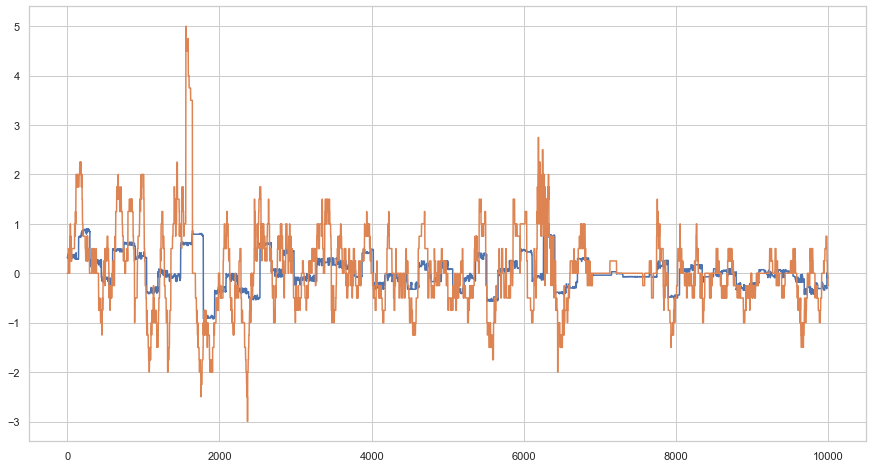

In [22]:
plt.subplots(1,1,figsize=(15,8))
plt.plot(predictions[:10000])
plt.plot(limited_test.y.values[:10000])

In [ ]:
# takes 1 min
predictions, limited_test = score(lgbm, scaler) # 0.95 most recent
''' 0.95 has scores of (0.0456, 0.0489, 0.0451)'''

In [ ]:
a = lgbm.feature_importances_; a

In [ ]:
limited_train.columns

In [23]:
sns.set(style='whitegrid')

In [ ]:
'''You should chuck the variables that meet this condition!'''
cols.values[np.where(a<10,1,0).astype(bool)]

In [ ]:
cols.values[np.where(a>100,1,0).astype(bool)]

In [ ]:
predictions, limited_test, df_mid_test = score(lasso)

# Fast.ai

In [ ]:
dep_var = 'y'
procs = [FillMissing, Normalize]

In [ ]:
# fillmissing replaces with median // fill with zero could be better

In [ ]:
# use a subset of training data
train_df = train_df[:int(5e5)]

In [ ]:
# takes 7s on 500k rows, 30s on full df
test = TabularList.from_df(test_df, procs=procs)
data = (TabularList.from_df(df = train_df, path='.', cont_names = df.columns.drop('y'), procs=procs)
                            .split_by_idx(valid_idx=range(int(0.50*len(train_df)),int(len(train_df))))
                            .label_from_df(cols=dep_var)
                            .add_test(test, label=0)
                            .databunch())

In [ ]:
learn = tabular_learner(data, layers=[500,200], metrics=[mean_absolute_error, r2_score], ps=[0.001,0.01])

In [ ]:
learn.model

In [ ]:
learn.lr_find(end_lr=1e1)

In [ ]:
sns.set(style = "whitegrid")

In [ ]:
learn.recorder.plot()

In [ ]:
# model above has already diverged, we will restart.

In [ ]:
# create pytorch resnet model






In [ ]:
# do some learning







In [ ]:
# 2m for 1 cycle
learn.fit_one_cycle(1, 5e-4, wd=0.01)

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('new_fastai')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.show_results()

In [ ]:
Learner.predict??

In [ ]:
df.iloc[:100].values.shape

In [ ]:
learn.predict(df.iloc[int(8.1e5)])

In [ ]:
df.y.iloc[int(8.1e5)]

In [ ]:
preds = learn.get_preds()

In [ ]:
Learner.get_preds??

# Submission testing

In [24]:
def get_next_data_as_df(test_df, iteration, length):
    return pd.DataFrame([test_df.head(length).iloc[iteration][:60].values])

In [25]:
'''
This function takes in a DataFrame row [df] of shape (1,60) and adds 10 cross-sectional features.
Returns a DataFrame of shape (1,70).
'''
def create_limited_features(df):
    df.columns = [*askRateList, *askSizeList, *bidRateList, *bidSizeList]
    # limited features
    df['midRate'] = (df.bidRate0 + df.askRate0) / 2 # necessary for ohlc
    df['bidAskVol'] = df.bidSize0 + df.askSize0 # necessary for ohlc
    df['OIR'] = (df.bidSize0 - df.askSize0)/(df.bidSize0 + df.askSize0)
    df['totalAskVol'] = df[askSizeList].sum(axis=1)
    df['totalBidVol'] = df[bidSizeList].sum(axis=1)
    df['OIR_total'] = (df.totalBidVol - df.totalAskVol)/(df.totalBidVol + df.totalAskVol)
    
    df['spread'] = df.askRate0 - df.bidRate0
    df['bidAskVol'] = df.askSize0 + df.bidSize0
    df['vwaBid'] = np.einsum('ij,ji->i', df[bidRateList], df[bidSizeList].T) / df[bidSizeList].sum(axis=1)
    df['vwaAsk'] = np.einsum('ij,ji->i', df[askRateList], df[askSizeList].T) / df[askSizeList].sum(axis=1)
    df['vwaBidDMid'] = df.midRate - df.vwaBid
    df['vwaAskDMid'] = df.vwaAsk - df.midRate
    df['diff_vwaBidAskDMid'] = df.vwaAskDMid - df.vwaBidDMid
    return df

In [26]:
''' Appends to [massive_df]=(many, >70) the DataFrame row [row]=(1,70). '''
def append_to_df(massive_df, row):
    try: row.index = [massive_df.index[-1] + timedelta(minutes=1)]
    except IndexError: row.index = [datetime(1970,1,1)]
    return massive_df.append(row, sort=False)

In [27]:
''' Adds time-dependent features. All features that use shift/diff must come here. '''
def add_time_features(df):
    return df[-150:]

In [30]:
def create_limited_features_orig(df, num):
    # resample features
    df['time'] = pd.date_range(start='1/1/1970', periods=len(df), freq='T')
    df.set_index('time', inplace=True)
    df_mid = df.midRate.resample(str(num)+'Min').ohlc()
    df_mid['vol'] = df.bidAskVol.resample('15Min').mean()
    def create_ohlc_features(df_mid, open_, high_, low_, close_, vol_):
        df_mid = ta.add_momentum_ta(df_mid, high_, low_, close_, vol_)
        df_mid = ta.add_others_ta(df_mid, close_)
        return df_mid
    df_mid = create_ohlc_features(df_mid, 'open', 'high', 'low', 'close', 'vol')
    df = df.join(df_mid[df_mid.columns.drop(['open', 'high', 'low', 'close', 'vol'])]).ffill().astype('float32')
    df.fillna(0, inplace=True)
    return df

In [39]:
def add_resample_features(massive_df, resampled_df):
    num = 149
    leftovers = (massive_df.index[-1].to_pydatetime().minute+1) % num
    def create_ohlc_features(df_mid, open_, high_, low_, close_, vol_):
        df_mid = ta.add_momentum_ta(df_mid, high_, low_, close_, vol_)
        df_mid = ta.add_others_ta(df_mid, close_)
        return df_mid
    def pad_history():
        full_resampled = resampled_df.append(row_ohlcv, sort=False)
        pad = pd.DataFrame([full_resampled.iloc[0] for j in range(14+1-len(full_resampled))]) # confirm need to edit this
        pad = pad.append(full_resampled, sort=False)
        pad.index = pd.date_range(start=row_ohlcv.index[-1], periods=len(pad), freq=('-'+str(num)+'Min')).sort_values()
        full_resampled = create_ohlc_features(pad, 'open', 'high', 'low', 'close', 'vol')
        return full_resampled
    row_ohlcv = massive_df.tail(num).midRate.resample(str(num)+'Min').ohlc().tail(1)
    row_ohlcv['vol'] = massive_df.tail(num).bidAskVol.resample(str(num)+'Min').mean()
    full_resampled = pad_history()
    if leftovers == 0:
        resampled_df = resampled_df.append(full_resampled, sort=False).tail(2) # take last 2 only
    try: massive_df.drop(cols, axis=1, inplace=True)
    except KeyError: pass
    massive_df = massive_df.join(full_resampled[cols])
    massive_df = massive_df.ffill().astype('float32')
    return massive_df, resampled_df

In [31]:
''' This function takes in all features and makes a bounded prediction. '''
def get_prediction(data, model):
    X = data.values
    X_scaled = scaler.transform(X)
    return np.clip(model.predict(np.atleast_2d(X_scaled)), -5, 5)[0]

In [36]:
''' true_rlcvscore runs the submission functions on a test dataframe [test_df] taking the first [length] rows of [test_df].'''
def true_rlcvscore(test_df, model, length):
    massive_df, resampled_df = pd.DataFrame(), pd.DataFrame()
    predictions = []
    log_data = pd.DataFrame()  # for debug
    for iteration in tqdm_notebook(range(length)):
        base_row = get_next_data_as_df(test_df, iteration, length)
        row = create_limited_features(base_row)
        massive_df = append_to_df(massive_df, row)
        massive_df = add_time_features(massive_df)
        massive_df, resampled_df = add_resample_features(massive_df, resampled_df)
        log_data_row = pd.DataFrame([massive_df.iloc[-1]]) # for debug
        data = pd.DataFrame([massive_df.iloc[-1]])
        prediction = get_prediction(data, model)
        predictions.append(prediction)
        log_data = log_data.append(log_data_row, sort=False)  # for debug
    true_values = test_df.y.head(length)
    score = r2d2(true_values, predictions)
    print(f'{score:.4f}')
    return predictions, score, log_data, true_values

In [37]:
# takes 2m30s
test_predictions, test_score, log_data, true_values = true_rlcvscore(test_df, lgbm, 1000)


-0.5898


In [59]:
limited_test.head(200)

,askRate0,askRate1,askRate2,askRate3,askRate4,askRate5,askRate6,askRate7,askRate8,askRate9,askRate10,askRate11,askRate12,askRate13,askRate14,askSize0,askSize1,askSize2,askSize3,askSize4,askSize5,askSize6,askSize7,askSize8,askSize9,askSize10,askSize11,askSize12,askSize13,askSize14,bidRate0,bidRate1,bidRate2,bidRate3,bidRate4,bidRate5,bidRate6,bidRate7,bidRate8,bidRate9,bidRate10,bidRate11,bidRate12,bidRate13,bidRate14,bidSize0,bidSize1,bidSize2,bidSize3,bidSize4,bidSize5,bidSize6,bidSize7,bidSize8,bidSize9,bidSize10,bidSize11,bidSize12,bidSize13,bidSize14,y,midRate,bidAskVol,OIR,totalAskVol,totalBidVol,OIR_total,spread,vwaBid,vwaAsk,vwaBidDMid,vwaAskDMid,diff_vwaBidAskDMid,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,6.0,15.0,36.0,3.0,33.0,4.0,8.0,1.0,9.0,2.0,1.0,33.0,3.0,2.0,1.0,1609.0,1608.5,1608.0,1607.5,1607.0,1606.5,1606.0,1605.5,1605.0,1604.5,1604.0,1603.5,1603.0,1602.5,1602.0,3.0,8.0,8.0,7.0,10.0,6.0,10.0,8.0,28.0,4.0,1.0,1.0,2.0,8.0,1.0,0.00,1609.25,9.0,-0.333333,157.0,105.0,-0.198473,0.5,1605.885742,1612.181519,3.364258,2.931519,-0.432739,0.0,100.0,100.0,100.0,100.0,100.0,-0.0,0.0,0.844836,0.000000,0.000000
1970-01-01 00:01:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,6.0,15.0,36.0,3.0,33.0,4.0,8.0,1.0,9.0,2.0,1.0,33.0,3.0,2.0,1.0,1609.0,1608.5,1608.0,1607.5,1607.0,1606.5,1606.0,1605.5,1605.0,1604.5,1604.0,1603.5,1603.0,1602.5,1602.0,3.0,7.0,8.0,7.0,10.0,6.0,11.0,8.0,28.0,4.0,1.0,1.0,2.0,8.0,1.0,0.00,1609.25,9.0,-0.333333,157.0,105.0,-0.198473,0.5,1605.861938,1612.181519,3.388062,2.931519,-0.456543,0.0,100.0,100.0,100.0,100.0,100.0,-0.0,0.0,0.844836,0.000000,0.000000
1970-01-01 00:02:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,6.0,14.0,36.0,3.0,33.0,4.0,9.0,1.0,9.0,2.0,1.0,33.0,3.0,2.0,1.0,1609.0,1608.5,1608.0,1607.5,1607.0,1606.5,1606.0,1605.5,1605.0,1604.5,1604.0,1603.5,1603.0,1602.5,1602.0,3.0,7.0,8.0,7.0,10.0,6.0,11.0,8.0,28.0,4.0,1.0,1.0,2.0,8.0,1.0,0.00,1609.25,9.0,-0.333333,157.0,105.0,-0.198473,0.5,1605.861938,1612.197510,3.388062,2.947510,-0.440552,0.0,100.0,100.0,100.0,100.0,100.0,-0.0,0.0,0.844836,0.000000,0.000000
1970-01-01 00:03:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,6.0,14.0,36.0,3.0,33.0,4.0,8.0,1.0,9.0,2.0,1.0,33.0,3.0,2.0,1.0,1609.0,1608.5,1608.0,1607.5,1607.0,1606.5,1606.0,1605.5,1605.0,1604.5,1604.0,1603.5,1603.0,1602.5,1602.0,3.0,7.0,8.0,7.0,10.0,6.0,11.0,8.0,28.0,4.0,1.0,1.0,2.0,8.0,1.0,0.00,1609.25,9.0,-0.333333,156.0,105.0,-0.195402,0.5,1605.861938,1612.195557,3.388062,2.945557,-0.442505,0.0,100.0,100.0,100.0,100.0,100.0,-0.0,0.0,0.844836,0.000000,0.000000
1970-01-01 00:04:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,6.0,14.0,37.0,3.0,33.0,4.0,8.0,1.0,9.0,2.0,1.0,33.0,3.0,2.0,1.0,1609.0,1608.5,1608.0,1607.5,1607.0,1606.5,1606.0,1605.5,1605.0,1604.5,1604.0,1603.5,1603.0,1602.5,1602.0,3.0,7.0,8.0,7.0,10.0,6.0,11.0,8.0,28.0,4.0,1.0,1.0,2.0,8.0,1.0,0.00,1609.25,9.0,-0.333333,157.0,105.0,-0.198473,0.5,1605.861938,1612.184692,3.388062,2.934692,-0.453369,0.0,100.0,100.0,100.0,100.0,100.0,-0.0,0.0,0.844836,0.000000,0.000000
1970-01-01 00:05:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,5.0,14.0,37.0,3.0,33.0,4.0,8.0,1.0,9.0,2.0,1.0,33.0,3.0,2.0,1.0,1609.0,1608.5,1608.0,1607.5,1607.0,1606.5,1606.0,1605.5,1605.0,1604.5,1604.0,1603.5,1603.0,1602.5,1602.0,3.0,7.0,8.0,7.0,10.0,6.0,11.0,8.0,28.0,4.0,1.0,1.0,2.0,8.0,1.0,0.00,1609.25,8.0,-0.250000,156.0,105.0,-0.195402,0.5,1605.861938,1612.

In [ ]:
''' The most important thing now is to reconcile the dataframes in submission and in batch prediction. '''

In [ ]:
''' Why is that that from 100 to 169 we have NANs? '''

In [45]:
log_data.head(200)

,askRate0,askRate1,askRate2,askRate3,askRate4,askRate5,askRate6,askRate7,askRate8,askRate9,askRate10,askRate11,askRate12,askRate13,askRate14,askSize0,askSize1,askSize2,askSize3,askSize4,askSize5,askSize6,askSize7,askSize8,askSize9,askSize10,askSize11,askSize12,askSize13,askSize14,bidRate0,bidRate1,bidRate2,bidRate3,bidRate4,bidRate5,bidRate6,bidRate7,bidRate8,bidRate9,bidRate10,bidRate11,bidRate12,bidRate13,bidRate14,bidSize0,bidSize1,bidSize2,bidSize3,bidSize4,bidSize5,bidSize6,bidSize7,bidSize8,bidSize9,bidSize10,bidSize11,bidSize12,bidSize13,bidSize14,midRate,bidAskVol,OIR,totalAskVol,totalBidVol,OIR_total,spread,vwaBid,vwaAsk,vwaBidDMid,vwaAskDMid,diff_vwaBidAskDMid,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
1970-01-01 00:00:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,6.0,15.0,36.0,3.0,33.0,4.0,8.0,1.0,9.0,2.0,1.0,33.0,3.0,2.0,1.0,1609.0,1608.5,1608.0,1607.5,1607.0,1606.5,1606.0,1605.5,1605.0,1604.5,1604.0,1603.5,1603.0,1602.5,1602.0,3.0,8.0,8.0,7.0,10.0,6.0,10.0,8.0,28.0,4.0,1.0,1.0,2.0,8.0,1.0,1609.25,9.0,-0.333333,157.0,105.0,-0.198473,0.5,1605.885742,1612.181519,3.364286,2.931529,-0.432757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1970-01-01 00:01:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,6.0,15.0,36.0,3.0,33.0,4.0,8.0,1.0,9.0,2.0,1.0,33.0,3.0,2.0,1.0,1609.0,1608.5,1608.0,1607.5,1607.0,1606.5,1606.0,1605.5,1605.0,1604.5,1604.0,1603.5,1603.0,1602.5,1602.0,3.0,7.0,8.0,7.0,10.0,6.0,11.0,8.0,28.0,4.0,1.0,1.0,2.0,8.0,1.0,1609.25,9.0,-0.333333,157.0,105.0,-0.198473,0.5,1605.861938,1612.181519,3.388095,2.931529,-0.456567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1970-01-01 00:02:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,6.0,14.0,36.0,3.0,33.0,4.0,9.0,1.0,9.0,2.0,1.0,33.0,3.0,2.0,1.0,1609.0,1608.5,1608.0,1607.5,1607.0,1606.5,1606.0,1605.5,1605.0,1604.5,1604.0,1603.5,1603.0,1602.5,1602.0,3.0,7.0,8.0,7.0,10.0,6.0,11.0,8.0,28.0,4.0,1.0,1.0,2.0,8.0,1.0,1609.25,9.0,-0.333333,157.0,105.0,-0.198473,0.5,1605.861938,1612.197510,3.388095,2.947452,-0.440643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1970-01-01 00:03:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,6.0,14.0,36.0,3.0,33.0,4.0,8.0,1.0,9.0,2.0,1.0,33.0,3.0,2.0,1.0,1609.0,1608.5,1608.0,1607.5,1607.0,1606.5,1606.0,1605.5,1605.0,1604.5,1604.0,1603.5,1603.0,1602.5,1602.0,3.0,7.0,8.0,7.0,10.0,6.0,11.0,8.0,28.0,4.0,1.0,1.0,2.0,8.0,1.0,1609.25,9.0,-0.333333,156.0,105.0,-0.195402,0.5,1605.861938,1612.195557,3.388095,2.945513,-0.442582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1970-01-01 00:04:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,6.0,14.0,37.0,3.0,33.0,4.0,8.0,1.0,9.0,2.0,1.0,33.0,3.0,2.0,1.0,1609.0,1608.5,1608.0,1607.5,1607.0,1606.5,1606.0,1605.5,1605.0,1604.5,1604.0,1603.5,1603.0,1602.5,1602.0,3.0,7.0,8.0,7.0,10.0,6.0,11.0,8.0,28.0,4.0,1.0,1.0,2.0,8.0,1.0,1609.25,9.0,-0.333333,157.0,105.0,-0.198473,0.5,1605.861938,1612.184692,3.388095,2.934713,-0.453382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1970-01-01 00:05:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,5.0,14.0,37.0,3.0,33.0,4.0,8.0,1.0,9.0,2.0,1.0,33.0,3.0,2.0,1.0,1609.0,1608.5,1608.0,1607.5,1607.0,1606.5,1606.0,1605.5,1605.0,1604.5,1604.0,1603.5,1603.0,1602.5,1602.0,3.0,7.0,8.0,7.0,10.0,6.0,11.0,8.0,28.0,4.0,1.0,1.0,2.0,8.0,1.0,1609.25,8.0,-0.250000,156.0,105.0,-0.195402,0.5,1605.861938,1612.201904,3.388095,2.951923,-0.436172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1970-01-01 00:06:00,1609.5,1610.0,1610.5,1611.0,1611.5,1612.0,1612.5,1613.0,1613.5,1614.0,1614.5,1615.0,1615.5,1616.0,1616.5,5.0,15.0,37.0,3.0,33.0,4.0,7.0,1.0,9.0,2.0,1.0,

In [ ]:
cols.values

In [ ]:
'''
Why is it that line-by-line gives: -0.5231, when batch gives -0.0744?
1. the joined values all become nans
2. the line-by-line 1k set is not a good measure of generalisability
'''

In [ ]:
plt.subplots(1,1,figsize=(15,8))
plt.plot(test_predictions)
plt.plot(true_values.values)
plt.legend(['predictions', 'y'])

In [ ]:
# %lprun -f true_rlcvscore test_predictions, test_score = true_rlcvscore(test_df, 100)